<a href="https://colab.research.google.com/github/claudwq/GAN_Practice/blob/master/GAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print('use cuda:', torch.cuda.get_device_name(0))
  pass

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

use cuda: Tesla K80


device(type='cuda')

In [4]:
class CelebADataset(Dataset):
  def __init__(self,file):
    self.file_object=h5py.File(file,'r')
    self.dataset=self.file_object['img_align_celeba']

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    if index>=len(self.dataset):
      raise IndexError()
    img=numpy.array(self.dataset[str(index)+'.jpg'])
    return torch.cuda.FloatTensor(img)/255.0

  def plot_image(self, index):
    plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
    pass

  pass
  

In [7]:
celeba_dataset=CelebADataset('mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py')

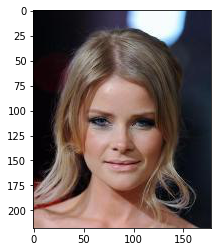

In [11]:
celeba_dataset.plot_image(9)

Helper Function

In [13]:
#function for generate random data

def generate_random_image(size):
  random_data=torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data=torch.randn(size)
  return random_data


In [22]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

  

Discriminator Network

In [27]:
#discriminator class

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    #define nn layer
    self.model=nn.Sequential(
        View(218*178*3),

        nn.Linear(3*218*178,100),

        nn.LeakyReLU(),

        nn.LayerNorm(100),
        nn.Linear(100,1),
        nn.Sigmoid()
    )
    self.loss_function=nn.BCELoss()

    #create loss function
    self.optimiser=torch.optim.Adam(self.parameters(), lr=0.0001)
    self.counter=0
    self.progress = []

    pass


  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs=self.forward(inputs)
    loss=self.loss_function(outputs, targets)
    self.counter+=1
    if(self.counter%10==0):
      self.progress.append(loss.item())
      pass

    if(self.counter%1000==0):
      print('counter=',self.counter)

    #zero gradients, perform a backward pass, update weights

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass

  def plot_progress(self):
    df=pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5,1.0,5.0))
    pass
  pass


In [29]:
%%time
D=Discriminator()

D.to(device)

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

  D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))

counter= 1000
counter= 2000
counter= 3000
counter= 4000
counter= 5000
counter= 6000
counter= 7000
counter= 8000
counter= 9000
counter= 10000
counter= 11000
counter= 12000
counter= 13000
counter= 14000
counter= 15000
counter= 16000
counter= 17000
counter= 18000
counter= 19000
counter= 20000
counter= 21000
counter= 22000
counter= 23000
counter= 24000
counter= 25000
counter= 26000
counter= 27000
counter= 28000
counter= 29000
counter= 30000
counter= 31000
counter= 32000
counter= 33000
counter= 34000
counter= 35000
counter= 36000
counter= 37000
counter= 38000
counter= 39000
counter= 40000
CPU times: user 5min 38s, sys: 5.97 s, total: 5min 44s
Wall time: 5min 45s


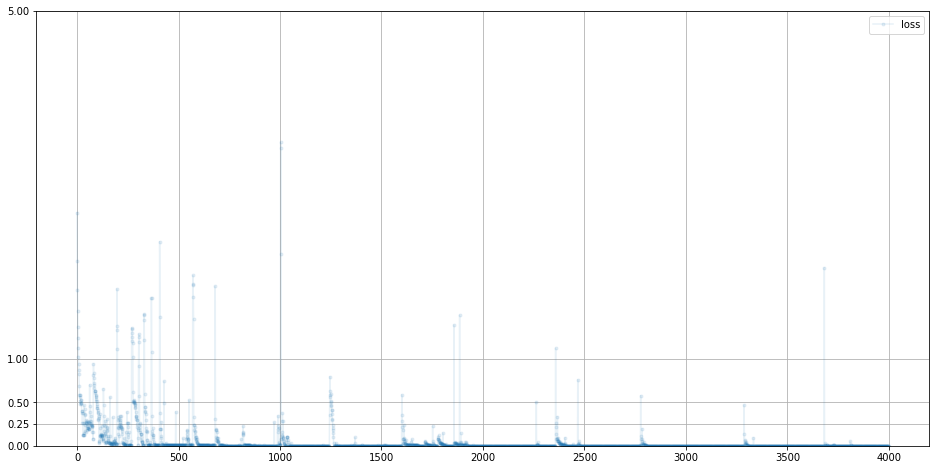

In [30]:
D.plot_progress()


In [31]:
for i in range(4):
  image_data_tensor=celeba_dataset[random.randint(0,20000)]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random_image((218,178,3))).item())

0.9999741315841675
0.9999868869781494
0.9998996257781982
0.9999761581420898
0.00010261679562972859
0.00010270490020047873
9.311999747296795e-05
0.00010162179387407377


Generator Network

In [40]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model=nn.Sequential(
        nn.Linear(100,3*10*10),
        nn.LeakyReLU(),
        nn.LayerNorm(3*10*10),
        nn.Linear(3*10*10,3*218*178),
        nn.Sigmoid(),
        View((218,178,3))
    )

    self.optimiser=torch.optim.Adam(self.parameters(),lr=0.0001)
    self.counter=0;
    self.progress=[]

    pass
  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    g_outputs=self.forward(inputs)

    d_ouput=D.forward(g_outputs)

    loss=D.loss_function(d_ouput, targets)

    self.counter +=1

    if (self.counter%10==0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df=pandas.DataFrame(self.progress,columns=['loss'])
    df.plot(ylim=(0),figsize=(16,8), alpha=0.1, marker='.',grid=True, yticks=(0,0.25,0.5,1.0,5.0))
    pass

  pass


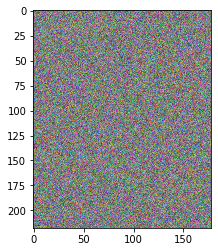

In [37]:
G=Generator()
G.to(device)

output=G.forward(generate_random_seed(100))
img=output.detach().cpu().numpy()
plt.imshow(img,interpolation='none',cmap='Blues')

In [41]:
%%time

D=Discriminator()
D.to(device)
G=Generator()
G.to(device)

epochs=2

for epoch in range(epochs):
  print('epoch=',epoch+1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor,torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100).detach()),torch.cuda.FloatTensor([0.0]))
    G.train(D,generate_random_seed(100),torch.cuda.FloatTensor([1.0]))
    pass

  pass

epoch= 1
counter= 1000
counter= 2000
counter= 3000
counter= 4000
counter= 5000
counter= 6000
counter= 7000
counter= 8000
counter= 9000
counter= 10000
counter= 11000
counter= 12000
counter= 13000
counter= 14000
counter= 15000
counter= 16000
counter= 17000
counter= 18000
counter= 19000
counter= 20000
counter= 21000
counter= 22000
counter= 23000
counter= 24000
counter= 25000
counter= 26000
counter= 27000
counter= 28000
counter= 29000
counter= 30000
counter= 31000
counter= 32000
counter= 33000
counter= 34000
counter= 35000
counter= 36000
counter= 37000
counter= 38000
counter= 39000
counter= 40000
epoch= 2
counter= 41000
counter= 42000
counter= 43000
counter= 44000
counter= 45000
counter= 46000
counter= 47000
counter= 48000
counter= 49000
counter= 50000
counter= 51000
counter= 52000
counter= 53000
counter= 54000
counter= 55000
counter= 56000
counter= 57000
counter= 58000
counter= 59000
counter= 60000
counter= 61000
counter= 62000
counter= 63000
counter= 64000
counter= 65000
counter= 66000
c

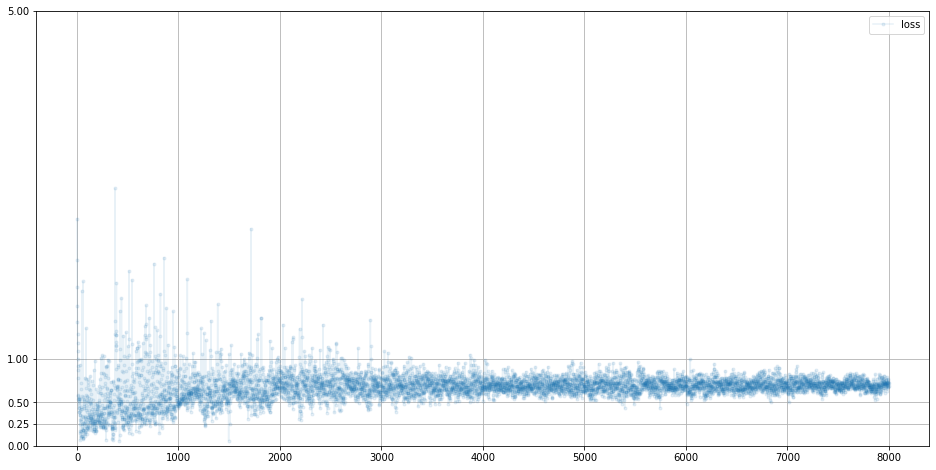

In [42]:
D.plot_progress()

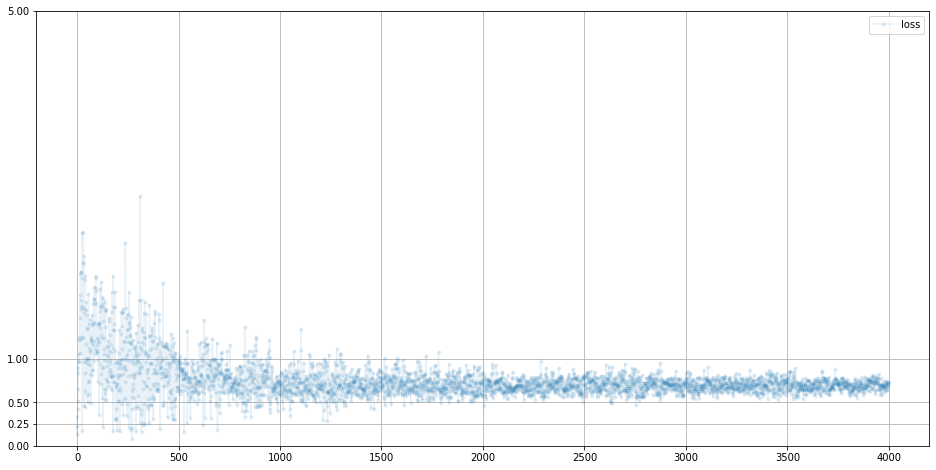

In [43]:
G.plot_progress()

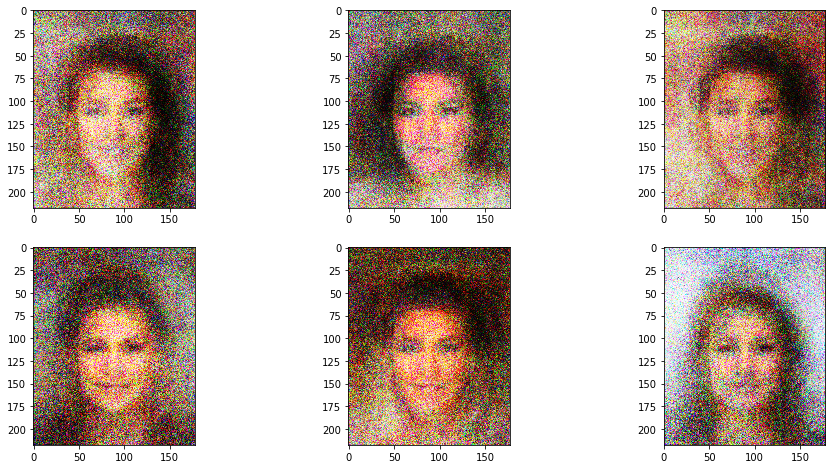

In [44]:
f,axarr = plt.subplots(2,3,figsize=(16,8))
for i in range(2):
  for j in range(3):
    output=G.forward(generate_random_seed(100))
    img=output.detach().cpu().numpy()
    axarr[i,j].imshow(img,interpolation='none',cmap='Blues')
    pass

  pass

Memory Consumption

In [45]:
torch.cuda.memory_allocated(device)/(1024*1024*1024)

1.180532455444336

In [46]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1208 MB |    1612 MB |   38542 GB |   38541 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1208 MB |    1612 MB |   38542 GB |   38541 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1768 MB |    1768 MB |    1768 MB |       0 B  |
|---------------------------------------------------------------